Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


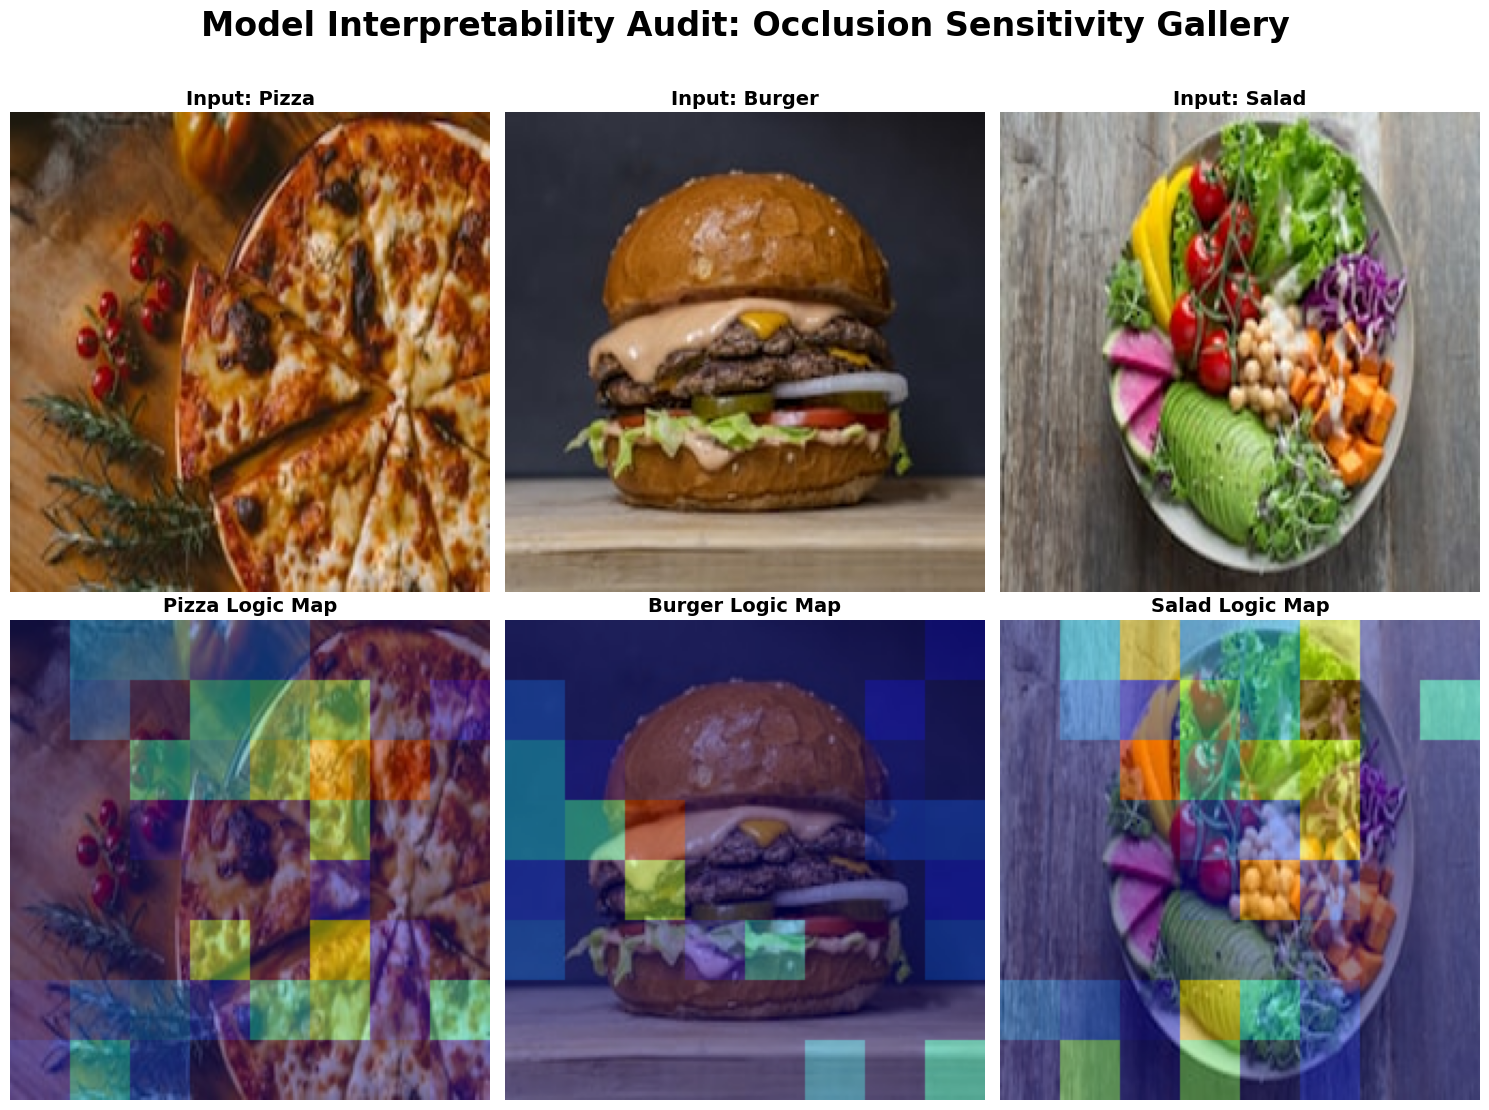

In [1]:
import os
import requests
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from io import BytesIO
from google.colab import drive

drive.mount("/content/drive")
model_path = "/content/drive/MyDrive/ai-food-analyzer/model_finetuned.keras"
model = tf.keras.models.load_model(model_path)

test_items = {
    "Pizza": "https://images.unsplash.com/photo-1513104890138-7c749659a591?q=80&w=224&auto=format&fit=crop",
    "Burger": "https://images.unsplash.com/photo-1568901346375-23c9450c58cd?q=80&w=224&auto=format&fit=crop",
    "Salad": "https://images.unsplash.com/photo-1512621776951-a57141f2eefd?q=80&w=224&auto=format&fit=crop"
}
# This audit uses Occlusion Sensitivity to identify 'Decision Zones'
# Red Areas = High Importance (The AI relies on these pixels).
# Blue Areas = Low Importance (background/noise)
def get_occlusion_heatmap(img_array, model, patch_size=28):
    preds = model.predict(img_array, verbose=0)
    class_index = np.argmax(preds[0])
    original_confidence = preds[0][class_index]

    height, width = img_array.shape[1], img_array.shape[2]
    heatmap = np.zeros((height, width))

    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            occluded_img = img_array.copy()
            occluded_img[0, y:y+patch_size, x:x+patch_size, :] = 0
            new_preds = model.predict(occluded_img, verbose=0)
            new_confidence = new_preds[0][class_index]
            # Difference in confidence = Importance of that area
            heatmap[y:y+patch_size, x:x+patch_size] = original_confidence - new_confidence

    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) > 0:
        heatmap /= np.max(heatmap)
    return heatmap

fig, axes = plt.subplots(2, 3, figsize=(15, 11))
headers = {'User-Agent': 'Mozilla/5.0'}

for i, (name, url) in enumerate(test_items.items()):
    try:
        response = requests.get(url, headers=headers)
        img_pil = Image.open(BytesIO(response.content)).convert('RGB')
        img_pil = img_pil.resize((224, 224))

        img_arr = np.array(img_pil) / 255.0
        img_arr_expanded = np.expand_dims(img_arr, axis=0)

        heatmap = get_occlusion_heatmap(img_arr_expanded, model)

        img_cv = np.array(img_pil)
        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_colored = plt.get_cmap("jet")(heatmap_resized)[:, :, :3]
        superimposed = cv2.addWeighted(img_cv, 0.6, np.uint8(255 * heatmap_colored), 0.4, 0)

        # Plot original top row
        axes[0, i].imshow(img_cv)
        axes[0, i].set_title(f"Input: {name}", fontsize=14, fontweight='bold')
        axes[0, i].axis("off")

        # Plot heatmap bottom row
        axes[1, i].imshow(superimposed)
        axes[1, i].set_title(f"{name} Logic Map", fontsize=14, fontweight='bold')
        axes[1, i].axis("off")

    except Exception as e:
        print(f"Error on {name}: {e}")

plt.suptitle("Model Interpretability Audit: Occlusion Sensitivity Gallery", fontsize=24, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()